In [2]:
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import hist
import hist.dask as hda
import dask
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

NanoAODSchema.warn_missing_crossrefs = False

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [3]:
import os
os.listdir('.')

['.ipynb_checkpoints',
 'samples.json',
 'fully_leptonic_test.ipynb',
 '.git',
 'resonancesTest.ipynb',
 'semileptonic_test.ipynb',
 'leading_W_jet_pt.h5',
 'semileptonic_notebooks.tar.gz']

In [43]:
# import json

# with open("semileptonic_notebooks/samples.json", 'r') as sample_file:
#     fileset = json.load(sample_file)

# for sample in fileset:
#     print(sample)

fileset = {
    'BulkGravToWW_1000': {
        'files': {
            'root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv7/BulkGravToWW_narrow_M-1000_13TeV-madgraph/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/100000/D4404DCB-FBF8-C640-87B0-2DA1D5139083.root': "Events",
        },
        'metadata': {
            'is_mc': 'Events',
        },
    },
    'RadionToWW_1000': {
        'files': {
            'root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv7/RadionToWW_narrow_M-1000_13TeV-madgraph/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/120000/B53216D7-B5CA-A347-A49A-5B055C71FB93.root': "Events",
        },
        'metadata': {
            'is_mc': 'Events',
        },
    }
}

In [74]:
test_dataset = 'RadionToWW_1000'
events = NanoEventsFactory.from_root(
    fileset[test_dataset]['files'],
    entry_stop = 10000,
    metadata = fileset[test_dataset]['metadata'],
    schemaclass = NanoAODSchema,
    delayed=False,
).events()

In [75]:
events.fields

['GenMET',
 'FatJet',
 'LHEReweightingWeight',
 'L1simulation',
 'btagWeight',
 'GenIsolatedPhoton',
 'HTXS',
 'luminosityBlock',
 'PSWeight',
 'LHEScaleWeight',
 'Jet',
 'SoftActivityJetNjets2',
 'genTtbarId',
 'SoftActivityJetNjets10',
 'GenJet',
 'GenDressedLepton',
 'event',
 'SoftActivityJetHT',
 'PV',
 'Photon',
 'fixedGridRhoFastjetCentralNeutral',
 'SoftActivityJetHT10',
 'SoftActivityJet',
 'CorrT1METJet',
 'LHEPart',
 'HLTriggerFirstPath',
 'HLT',
 'SV',
 'RawPuppiMET',
 'SoftActivityJetNjets5',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'LHE',
 'GenJetAK8',
 'FsrPhoton',
 'fixedGridRhoFastjetCentral',
 'run',
 'SubJet',
 'Muon',
 'PuppiMET',
 'CaloMET',
 'HLTriggerFinalPath',
 'L1',
 'Generator',
 'TkMET',
 'SoftActivityJetHT5',
 'LHEPdfWeight',
 'RawMET',
 'Pileup',
 'L1PreFiringWeight',
 'SubGenJetAK8',
 'IsoTrack',
 'fixedGridRhoFastjetCentralCalo',
 'GenVisTau',
 'ChsMET',
 'LHEWeight',
 'OtherPV',
 'GenPart',
 'SoftActivityJetHT2',
 'fixedGridRhoFastjetAll',
 'Flag',


In [7]:
# Samples from 2018...

muons = events.Muon
electrons = events.Electron

# Exactly one tightly identified electron or muon
electron_pt_threshold = 35
muon_pt_threshold = 30
pt_miss_threshold = 30

# Muon TightHWW selection
muons_tightHWW = muons[
    (muons.pt > 10) &
    (np.abs(muons.eta) < 2.4) &
    (muons.tightId) &
    (
        ((muons.pt < 20) & (np.abs(muons.dxy) < 0.01)) |
        ((muons.pt >= 20) & (np.abs(muons.dxy) < 0.02))
    ) &
    (np.abs(muons.dz) < 0.1) &
    # particle flow isolated: tight or greater
    (muons.pfIsoId >= 4)
]

In [ ]:
loose_muons = muons[muons.looseId]
loose_muon_count = ak.num(loose_muons[loose_muons.pt > 10])

loose_electrons = electrons[(electrons.cutBased >= 2)]
loose_electron_count = ak.num(loose_electrons[loose_electrons.pt > 10])

# Mask for vetoing extra loose leptons
loose_lepton_veto_mask = (loose_muon_count + loose_electron_count) == 1

In [76]:

clean_fatJets = events.FatJet[(events.FatJet.pt > 200) & (np.abs(events.FatJet.eta) < 2.4)]



In [77]:
#Jets cuts
clean_Jets = events.Jet[(events.Jet.pt > 30) & (np.abs(events.Jet.eta) < 4.7)]

#Removing AK4(Jet) jets overlapping with AK8(FatJets) jets
# Get all combinations of jets and fatjets in every event
jets_fatjets = ak.cartesian({"x": clean_Jets, "y": clean_fatJets})
# Check that jets satisfy the isolation
jets_iso_f = ((jets_fatjets["x"].eta-jets_fatjets["y"].eta)**2+(jets_fatjets["x"].phi-jets_fatjets["y"].phi)**2>0.8**2)
# Mask the jets_fatjets with the jets_iso_f to get jets isolated from fatjets
jets_fatjets = jets_fatjets[jets_iso_f]
# Separate pairs into jets and fatjets, redefining the jets (but not the fatjets)
jets, fj = ak.unzip(jets_fatjets)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f80174ce1e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

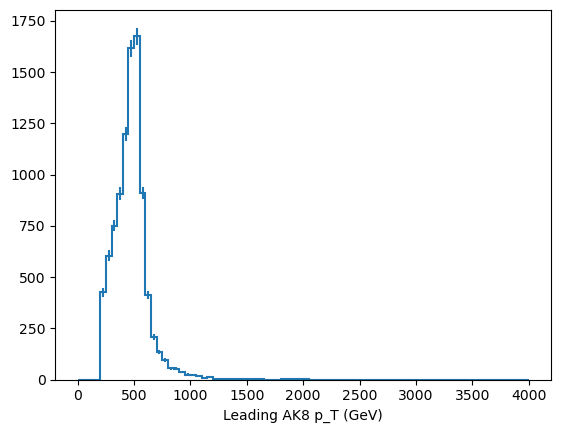

In [78]:
AK8jets_candidates_mask = ak.num(clean_fatJets) >= 1

Wjets_candidates = clean_fatJets[AK8jets_candidates_mask]
leading_W_jet = Wjets_candidates[:, 0]
leading_W_jet_pt = leading_W_jet.pt

leading_W_pt_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="Dataset", categories=[], growth=True),
                            hist.axis.Regular(name='leading_AK8_pt', label='Leading AK8 p_T (GeV)', bins=80, start=0, stop=4000))
leading_W_pt_hist.fill(dataset=test_dataset, leading_AK8_pt=leading_W_jet_pt)
leading_W_pt_hist.plot1d()

In [59]:
# basic h5 creation
import pandas as pd
# Convert awkward array to numpy array (flat)
leading_W_jet_pt_np = ak.to_numpy(leading_W_jet_pt)
leading_W_jet_eta_np = ak.to_numpy(leading_W_jet.eta)
# Optional — wrap in a DataFrame for easy labeling
df_leading_W_jet_pt = pd.DataFrame({'leading_W_jet_pt': leading_W_jet_pt_np, 'leading_W_jet_eta': leading_W_jet_eta_np})


In [49]:
df_leading_W_jet_pt.to_hdf('leading_W_jet_pt.h5', key='df', mode='w')


In [79]:
import vector
# Example FatJet (your "boson")
fatjet_p4 = ak.zip({
    "pt": Wjets_candidates.pt,
    "eta": Wjets_candidates.eta,
    "phi": Wjets_candidates.phi,
    "mass": Wjets_candidates.mass,
}, with_name="Momentum4D")

In [51]:
pd.read_hdf('leading_W_jet_pt.h5')


,leading_W_jet_pt,leading_W_jet_eta
0,366.250,0.178833
1,443.250,-0.152985
2,480.000,-1.210205
3,319.750,-1.611572
4,474.750,-0.145081
...,...,...
9194,240.625,-1.124023
9195,377.750,-0.402466
9196,344.000,-1.494141
9197,606.000,-0.218109


In [80]:
# Let's say we want the boost that brings the first two FatJets into the CM frame.
# Step 1: Convert to Lorentz vectors
fatjet_p4 = ak.zip({
    "pt": Wjets_candidates.pt,
    "eta": Wjets_candidates.eta,
    "phi": Wjets_candidates.phi,
    "mass": Wjets_candidates.mass,
}, with_name="Momentum4D")



In [81]:
# Select SubJets based on indices stored in the selected FatJets
subjet_idx1 = Wjets_candidates.subJetIdx1
subjet_idx2 = Wjets_candidates.subJetIdx2

# Create a mask to select valid indices (some entries might be -1)
valid = (subjet_idx1 >= 0) & (subjet_idx2 >= 0)

# Apply mask to Wjets_candidates
Wjets_with_subjets = Wjets_candidates[valid]
idx1 = subjet_idx1[valid]
idx2 = subjet_idx2[valid]

subjet_idx1 = subjet_idx1[valid]
subjet_idx2 = subjet_idx2[valid]

subjet_idx1 = Wjets_candidates.subJetIdx1
subjet_idx2 = Wjets_candidates.subJetIdx2

# Only keep jets where both indices are valid
valid_mask = (subjet_idx1 >= 0) & (subjet_idx2 >= 0)

# Apply mask to subjet indices
subjet_idx1_valid = subjet_idx1[valid_mask]
subjet_idx2_valid = subjet_idx2[valid_mask]

flat_idx1 = ak.flatten(subjet_idx1_valid)
flat_idx2 = ak.flatten(subjet_idx2_valid)

# Also flatten the matching FatJets
flat_fatjets = ak.flatten(Wjets_candidates[valid_mask])

# Flatten SubJets per event
all_subjets = ak.flatten(events.SubJet, axis=1)

# Get the matched subjets
subjet1 = all_subjets[flat_idx1]
subjet2 = all_subjets[flat_idx2]

In [85]:
# Mask fat jets passing cuts
fatjet_mask = (events.FatJet.pt > 200) & (np.abs(events.FatJet.eta) < 2.4)

# Select only those fat jets
selected_fatjets = events.FatJet[fatjet_mask]


# This works with BulkGraviton But not Radion 
clean_SubJets = events.SubJet[(events.FatJet.pt > 200) & (np.abs(events.FatJet.eta) < 2.4)]

AK8subjets_candidates_mask = ak.num(clean_SubJets) >= 1

Wjets_candidates_subjets= clean_SubJets[AK8subjets_candidates_mask]

TypeError: mask() got an unexpected keyword argument 'axis'

<class 'vector.backends.awkward.MomentumArray3D'>
<class 'vector.backends.awkward.MomentumArray3D'>
[{x: 0.456, y: -0.841, z: 0.29}, {x: ..., ...}, ..., {x: 0.447, y: 0.894, z: 0}]
[{x: -0.717, y: -0.582, z: 0.382}, {...}, ..., {x: 0.513, y: -0.806, z: 0.295}]
[0.273, 0.671, 0.439, 0.143, 0.544, ..., 0.0861, 0.716, -0.966, 0.313, -0.492]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8025fe74a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

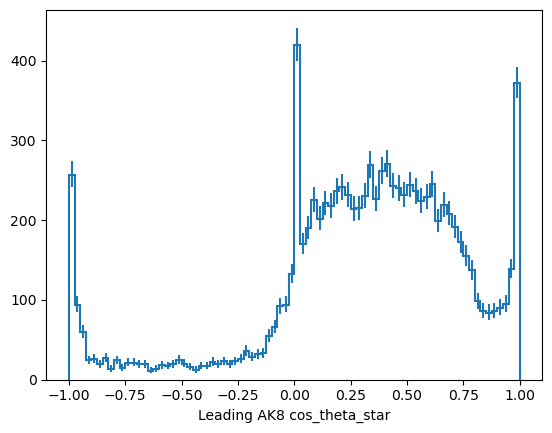

In [73]:
# print(fatjet_p4[:,0])
subjet_p4 = ak.zip({
    "pt": Wjets_candidates_subjets.pt,
    "eta": Wjets_candidates_subjets.eta,
    "phi": Wjets_candidates_subjets.phi,
    "mass": Wjets_candidates_subjets.mass,
}, with_name="Momentum4D")
# Step 2: Compute the boost to CM frame
#boost_vectors = subjet_p4[:,0].boostCM_of_p4(fatjet_p4[:,0])

# # Step 3: Apply the boost to each jet
# # This gives the FatJets *in the CM frame of the system*
# fj_boosted = fj_vectors.boost(boost_vectors)
# p_boson: Momentum4D vector of the vector boson candidate
# p_decay: Momentum4D vector of one of its decay products (e.g. the lepton or leading subjet)

# Step 1: Compute the CM frame boost of the boson
W_p4 = ak.sum(subjet_p4, axis=1)

# Step 3: Get boost vector — the **negative 3-momentum** of W divided by its energy
boost_vec = -W_p4.to_Vector3D() / W_p4.energy

# Step 4: Boost the subjets into the W rest frame
subjets_cm = subjet_p4.boost(boost_vec)


decay_product = subjets_cm[:, 0]  # pick leading subjet
W_direction = W_p4.to_Vector3D().unit()

decay_vec3 = decay_product.to_Vector3D()
decay_unit = decay_vec3.unit()   # property, no ()

print(type(decay_unit))
print(type(W_direction))
print(decay_unit)
print(W_direction)

cos_theta_star = decay_unit.dot(W_direction)  # this returns an awkward array of floats
#W_direction
print(cos_theta_star)#cos_theta_star = decay_product.to_Vector3D().unit() @ W_direction()  # cos(theta*)

leading_cos_theta_star_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="Dataset", categories=[], growth=True),
                            hist.axis.Regular(name='leading_AK8_cos_theta_star', label='Leading AK8 cos_theta_star', bins=80, start=-1, stop=1))
leading_cos_theta_star_hist.fill(dataset=test_dataset, leading_AK8_cos_theta_star=cos_theta_star)
leading_cos_theta_star_hist.plot1d()

ImportError: cannot import name 'CosTheta' from 'vector._compute' (/usr/local/lib/python3.12/site-packages/vector/_compute/__init__.py)

AssertionError: <ThreeVectorArray [[{rho: 349, phi: 1.65, ...}, ...], ...] type='10000 * va...'>

TypeError: <VectorArray3D [[{px: 21, py: -325, ...}, ...], ...] type='10000 * var * Ve...'> is not a 4D vector

AttributeError: 'MomentumNumpy4D' object has no attribute 'boostvec'

AttributeError: module 'awkward' has no attribute 'stack'

AttributeError: no field named 'boost'